### Customer Segmentation and Value Stratification via RFM Metrics
- This project analyzes customer transactional behavior using RFM (Recency, Frequency, Monetary) metrics to identify patterns, segment customers, and support data-driven decision-making. By examining purchase recency, transaction frequency, and monetary value, the analysis classifies customers into distinct tiers, enabling businesses to target high-value segments, optimize marketing strategies, and improve retention.

- The dataset has 5 columns
   - __customer_id__ - To uniquely identify each customer.
   - __transaction_date__ -The exact date when the transaction took place.
   - __amount__ - the total amount spent on each transaction
   - __purchase_channel__ - Channel through which the transaction was made.
   - __Customer_city__ - Location of the customer

##### 1.Data Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Reading the dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\customer_data.csv")
df.head()

,customer_id,transaction_date,amount,purchase_channel,customer_city
0,9004,2020-09-01,69.51,MobileApp,Eldoret
1,43838,2020-08-23,73.40,Online,Nakuru
2,110,2023-12-28,54.72,MobileApp,Mombasa
3,51792,2022-07-01,0.00,Online,Kisumu
4,17376,2022-12-14,66.89,Store,Mombasa


In [3]:
#Check for data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155000 entries, 0 to 154999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       155000 non-null  int64  
 1   transaction_date  155000 non-null  object 
 2   amount            155000 non-null  float64
 3   purchase_channel  155000 non-null  object 
 4   customer_city     155000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.9+ MB


In [4]:
# Check for duplicates
df.duplicated().sum()
print("There are {} rows of duplicates". format(df.duplicated().sum()))
# Drop the duplicates
df = df.drop_duplicates()
print("Rows after removing duplicates: 150,000")

There are 5000 rows of duplicates
Rows after removing duplicates: 150,000


In [5]:
#Check for null values
df.isnull().sum()

customer_id         0
transaction_date    0
amount              0
purchase_channel    0
customer_city       0
dtype: int64

In [21]:
#Convert transaction date to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors='coerce')
df.head()

,customer_id,transaction_date,amount,purchase_channel,customer_city
0,9004,2020-09-01,69.51,MobileApp,Eldoret
1,43838,2020-08-23,73.40,Online,Nakuru
2,110,2023-12-28,54.72,MobileApp,Mombasa
3,51792,2022-07-01,0.00,Online,Kisumu
4,17376,2022-12-14,66.89,Store,Mombasa


##### 2. Exploratory data analysis
- Which cities have the most frequent buyers

In [6]:
# Cities with the most unique customers
frequent_buyers = df.groupby("customer_city")["customer_id"].nunique().sort_values(ascending=False).reset_index(name="unique_customers")
frequent_buyers

,customer_city,unique_customers
0,Nairobi,23726
1,Kisumu,23679
2,Eldoret,23624
3,Nakuru,23558
4,Mombasa,23555


- Which cities have the highest number of customers who spend most per purchase?

In [7]:
# Average spending per customer by city
avg_spent_per_customer = (round(
    (df.groupby("customer_city")["amount"].sum() / df.groupby("customer_city")["customer_id"].nunique())
    .reset_index(name="avg_spent"),2)
)
avg_spent_per_customer = avg_spent_per_customer.sort_values(by="avg_spent", ascending=False)
avg_spent_per_customer


,customer_city,avg_spent
3,Nairobi,87.05
2,Mombasa,86.96
4,Nakuru,86.95
1,Kisumu,86.84
0,Eldoret,86.75


- Top frequent buyers (individuals) and their cities


In [8]:
# Identify the most frequent individual buyers
frequent_buyers = df.groupby(["customer_id", "customer_city"]).size().reset_index(name='purchase_count')
frequent_buyers = frequent_buyers.sort_values("purchase_count", ascending=False)
frequent_buyers.head(10)

,customer_id,customer_city,purchase_count
80491,40943,Eldoret,6
73636,37457,Nairobi,6
76740,39050,Nairobi,6
75360,38320,Kisumu,6
15940,8112,Kisumu,5
34891,17670,Nakuru,5
52233,26557,Eldoret,5
65343,33232,Nairobi,5
40507,20542,Kisumu,5
19837,10077,Eldoret,5


- Which purchase channel generates the most revenue

In [9]:
#Identify which channel generates the most revenue
purchase_channel_revenue = df.groupby("purchase_channel")["amount"].sum().reset_index(name="revenue")
purchase_channel_revenue = purchase_channel_revenue.sort_values(by="revenue", ascending=False)
purchase_channel_revenue

,purchase_channel,revenue
2,Online,3086338.77
3,Store,3072374.77
1,MobileApp,2058764.43
0,Agent,2049973.24


##### 3. Recency, Frequency and Monetary Value (RFM) analysis
- Recency
- Recency must reflect days since last purchase,therefore, large values means inactivity. Ranking must give higher scores to most recent customers,meaning reverse the rank relative to numeric recency value

In [ ]:
# Calculate the recency of purchases per customer ID
df_recency = df.groupby("customer_id",as_index=False)["transaction_date"].max()
df_recency.columns = ["customer_id", "last_purchase_date"]
df_recency["last_purchase_date"] = pd.to_datetime(df_recency["last_purchase_date"],errors="coerce")
#Calculate the recent date
recent_date = df["transaction_date"].max()
df_recency["recency"] = (recent_date - df_recency["last_purchase_date"]).dt.days
df_recency.head()

,customer_id,last_purchase_date,recency
0,1,2022-11-01,792
1,3,2022-11-05,788
2,4,2024-02-25,311
3,5,2024-08-21,133
4,6,2024-12-23,9


- Frequency
- How often does a customer make a purchase

In [ ]:
#Calculate the frequency of customer visits
df_frequency = df.groupby("customer_id",as_index=False).size()
df_frequency.columns = ["customer_id","frequency"]
df_frequency.head()

,customer_id,frequency
0,1,4
1,3,4
2,4,2
3,5,2
4,6,5


- Monetary Value
- How much does a customer spend 

In [27]:
# Calculate the monetary value of each customer per visit
df_monetary_value = round(df.groupby("customer_id", as_index=False)["amount"].sum(),2)
df_monetary_value.columns =["customer_id","monetary_value"]
df_monetary_value.head()

,customer_id,monetary_value
0,1,222.69
1,3,337.21
2,4,130.95
3,5,77.58
4,6,287.90


- Merge Recency,Frequency and Monetary value (RFM)

In [29]:
#Merge r,f,m
df_rfm =(
    df_recency
    .merge(df_frequency, on = "customer_id")
    .merge(df_monetary_value, on="customer_id")
)
df_rfm.head()


,customer_id,last_purchase_date,recency,frequency,monetary_value
0,1,2022-11-01,792,4,222.69
1,3,2022-11-05,788,4,337.21
2,4,2024-02-25,311,2,130.95
3,5,2024-08-21,133,2,77.58
4,6,2024-12-23,9,5,287.90


- Rank customers based on recency, frequency, and monetary value.


In [34]:
#Calculate the customer rank
df_rfm["recency_rank"] = df_rfm["recency"].rank(method="dense", ascending = True)
df_rfm["frequency_rank"] = df_rfm["frequency"].rank(method = "dense", ascending = False)
df_rfm["monetary_value_rank"] = df_rfm["monetary_value"].rank(method = "dense", ascending = False)
#Normalize the ranks
df_rfm["recency_rank_norm"] = (df_rfm["recency_rank"]/df_rfm["recency_rank"].max())*100
df_rfm["frequency_rank_norm"] = (df_rfm["frequency_rank"]/df_rfm["frequency_rank"].max())*100
df_rfm['monetary_value_rank_norm'] = (df_rfm["monetary_value_rank"]/df_rfm["monetary_value_rank"].max())*100
# Drop indiviadual ranks
df_rfm =df_rfm.drop(columns=["recency_rank","frequency_rank","monetary_value_rank"])
df_rfm.head()

,customer_id,last_purchase_date,recency,frequency,monetary_value,recency_rank_norm,frequency_rank_norm,monetary_value_rank_norm
0,1,2022-11-01,792,4,222.69,43.380744,72.727273,41.512126
1,3,2022-11-05,788,4,337.21,43.161926,72.727273,16.962479
2,4,2024-02-25,311,2,130.95,17.067834,90.909091,66.997313
3,5,2024-08-21,133,2,77.58,7.330416,90.909091,82.317619
4,6,2024-12-23,9,5,287.90,0.547046,63.636364,26.115516


- Calculate the RFM score


In [36]:
# Calculate the rfm score
df_rfm["rfm_score"] =((
    0.15* df_rfm["recency_rank_norm"] +
    0.28  * df_rfm["frequency_rank_norm"] +
    0.57 * df_rfm["monetary_value_rank_norm"]
)/20).round(2)
df_rfm.head()

,customer_id,last_purchase_date,recency,frequency,monetary_value,recency_rank_norm,frequency_rank_norm,monetary_value_rank_norm,rfm_score
0,1,2022-11-01,792,4,222.69,43.380744,72.727273,41.512126,2.53
1,3,2022-11-05,788,4,337.21,43.161926,72.727273,16.962479,1.83
2,4,2024-02-25,311,2,130.95,17.067834,90.909091,66.997313,3.31
3,5,2024-08-21,133,2,77.58,7.330416,90.909091,82.317619,3.67
4,6,2024-12-23,9,5,287.90,0.547046,63.636364,26.115516,1.64


##### 4. RFM Segmentation

In [39]:
# Customer segmentation using RFM score
df_rfm["customer_segment"] =np.where(
    df_rfm["rfm_score"] > 4.5, "Premium Customer",
    np.where(df_rfm["rfm_score"]> 4, "Loyal Customer",
    np.where(df_rfm["rfm_score"]> 3 , "Mid Value Stable Customer",
    np.where(df_rfm["rfm_score"]>1.6, "Low Engagement Customer",
            "Lost Customer" )))
    
)
df_rfm[["customer_id", "rfm_score","customer_segment"]].head(10)

,customer_id,rfm_score,customer_segment
0,1,2.53,Low Engagement Customer
1,3,1.83,Low Engagement Customer
2,4,3.31,Mid Value Stable Customer
3,5,3.67,Mid Value Stable Customer
4,6,1.64,Low Engagement Customer
5,7,3.80,Mid Value Stable Customer
6,8,0.87,Lost Customer
7,9,4.16,Loyal Customer
8,10,3.81,Mid Value Stable Customer
9,12,4.36,Loyal Customer


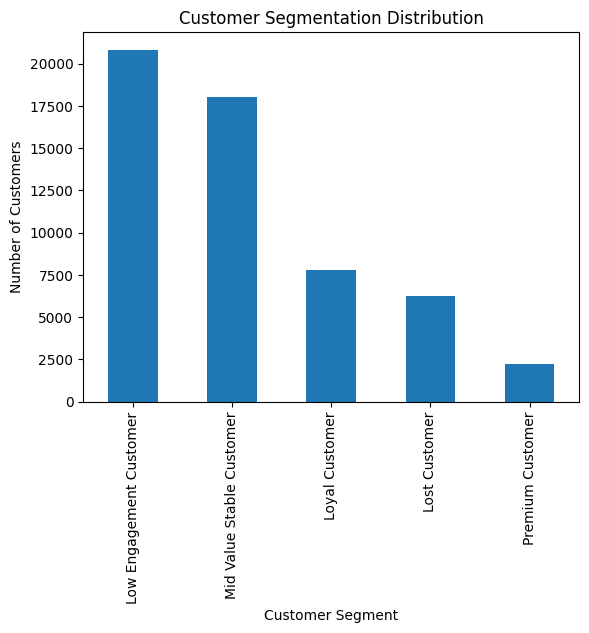

In [42]:
#Visualize the customer segment
segment_counts = df_rfm["customer_segment"].value_counts()
segment_counts.plot(kind='bar')
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.title ("Customer Segmentation Distribution");